# Basic imports

In [6]:
%load_ext autoreload
%autoreload 2
import sys, os, time
import requests, zipfile, io

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Download the data used by the simulator

In [7]:
# Download UCI Adult dataset
dir = 'data/income'
os.makedirs(dir, exist_ok=True)
uci_url = 'http://archive.ics.uci.edu/static/public/2/adult.zip'

r = requests.get(uci_url)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall(dir)

# Generate data using the simulator and save

In [8]:
# Generate 50 000 observations with horizon 10 (Took about 6 min on standard Colab resource)
start = time.time()
%run generate.py -n 50000 -T 10 
end = time.time()

print('Elapsed: %.2f minutes' % ((end - start)/60.))

Initializing ARM model ...
Fitting ARM model (suppressing warnings) ...


KeyboardInterrupt: 

Elapsed: 0.04 minutes


<br/><br/>
# [Let's go back to the slides...]
<br/><br/>

# Import packages for machine learning analysis

In [3]:
# Data representation, linear algebra
import numpy as np
import pandas as pd

# Machine learning
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.metrics import roc_auc_score, r2_score
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.calibration import calibration_curve

# Plotting
import matplotlib.pyplot as plt
plt.rc('font', size=18)
plt.rc('figure', figsize=(7,5))

# Load and inspect the data

In [9]:
df = pd.read_pickle('data/income_default_n50000_T10_s0.pkl')
df

,native-country,sex,race,age,education,workclass,occupation,marital-status,relationship,capital-net,hours-per-week,education-num,income_current,studies,income
0,United-States,Female,White,53.0,Assoc-acdm,Private,Sales,Widowed,Unmarried,0.0,8.0,12.0,40559.0,Evening course,106676.0
1,United-States,Female,White,44.0,Assoc-acdm,Private,Exec-managerial,Never-married,Not-in-family,-0.0,30.0,12.0,30127.0,Evening course,84934.0
2,United-States,Male,White,47.0,Masters,Self-emp-inc,Exec-managerial,Married,Not-in-family,0.0,52.0,14.0,136003.0,No studies,160004.0
3,United-States,Male,Black,34.0,HS-grad,Private,Machine-op-inspct,Never-married,Husband,0.0,14.0,9.0,12450.0,No studies,90952.0
4,United-States,Male,White,49.0,10th,Private,Transport-moving,Married,Husband,0.0,85.0,6.0,56568.0,Evening course,168134.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,United-States,Male,White,36.0,HS-grad,Private,Exec-managerial,Never-married,Own-child,-4955.0,69.0,9.0,96083.0,Evening course,124680.0
49996,United-States,Male,White,41.0,Bachelors,Private,Exec-managerial,Married,Husband,0.0,65.0,13.0,121681.0,Evening course,185118.0
49997,United-States,Male,White,52.0,7th-8th,Private,Transport-moving,Married,Other-relative,0.0,54.0,4.0,0.0,Full-time studies,119330.0
49998,United-States,Male,White,24.0,Bachelors,Private,Exec-managerial,Never-married,Not-in-family,-0.0,56.0,13.0,18770.0,No studies,124056.0


## Inspect the dataframe

### Covariates
Variable name | Meaning
 --- | ---
native-country | Native country (categorical)
sex | Self-reported sex (binary)
race | Self-reported race (categorical)
age | Age (continuous)
education | Education level (categorical)
workclass | Class of job (categorical)
occupation | Type of job (categorical)
marital-status | Marital status (categorical)
relationship | Type of relationship / household (categorical) 
capital-net | Yearly change in capital (continuous)
hours-per-week | Number of work hours per week (continuous)
income_current | Current yearly income in USD (continuous)
education-num | Numeric interpretation of education (continuous)

### Treatment
Variable name | Meaning
 --- | ---
studies | Type of studies (categorical)

### Outcome
Variable name | Meaning
 --- | ---
income | Yearly income in USD **after 10 years**


### What are the types of studies?

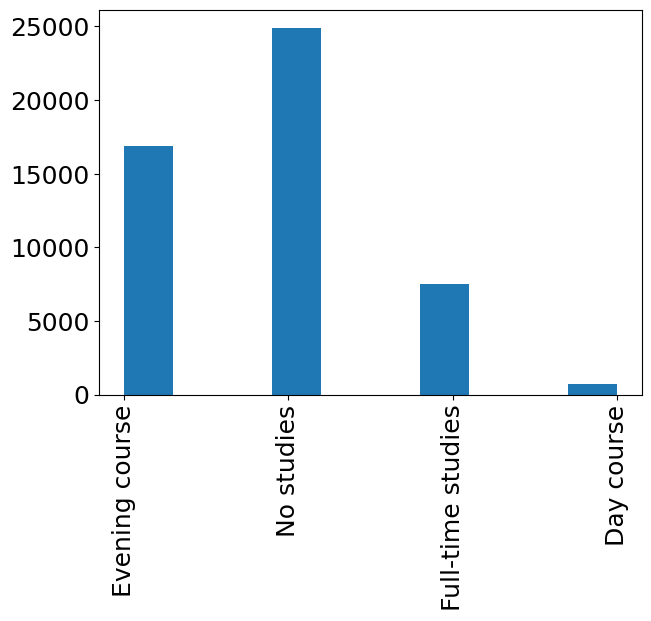

In [11]:
# The treatment variable
t_col = 'studies'

plt.hist(df[t_col])
plt.xticks(rotation=90)
plt.show()

<br/><br/>
# Let's figure out our goal [first... back to the slides]
<br/><br/>

# Let's define our outcome variable and adjustment set

In [18]:
# The outcome column
y_col = 'income'

# The adjustment set
a_cols = ['education', 'sex', 'age', 'income_current', 'relationship']

# All covariates
x_cols = [c for c in df.columns if not c in [t_col, y_col]]

df[a_cols]

,education,sex,age,income_current,relationship
0,Assoc-acdm,Female,53.0,40559.0,Unmarried
1,Assoc-acdm,Female,44.0,30127.0,Not-in-family
2,Masters,Male,47.0,136003.0,Not-in-family
3,HS-grad,Male,34.0,12450.0,Husband
4,10th,Male,49.0,56568.0,Husband
...,...,...,...,...,...
49995,HS-grad,Male,36.0,96083.0,Own-child
49996,Bachelors,Male,41.0,121681.0,Husband
49997,7th-8th,Male,52.0,0.0,Other-relative
49998,Bachelors,Male,24.0,18770.0,Not-in-family


In [21]:
# We only want to study 'Full-time studies' vs 'No studies'
# Let's restrict our dataframe to these

df = df[df['studies'].isin(['Full-time studies', 'No studies'])]
df

,native-country,sex,race,age,education,workclass,occupation,marital-status,relationship,capital-net,hours-per-week,education-num,income_current,studies,income
2,United-States,Male,White,47.0,Masters,Self-emp-inc,Exec-managerial,Married,Not-in-family,0.0,52.0,14.0,136003.0,No studies,160004.0
3,United-States,Male,Black,34.0,HS-grad,Private,Machine-op-inspct,Never-married,Husband,0.0,14.0,9.0,12450.0,No studies,90952.0
5,United-States,Female,White,42.0,Some-college,Local-gov,Adm-clerical,Married,Wife,0.0,47.0,10.0,0.0,Full-time studies,138805.0
6,United-States,Male,White,30.0,HS-grad,State-gov,Tech-support,Never-married,Other-relative,-0.0,8.0,9.0,0.0,Full-time studies,171897.0
10,United-States,Female,White,26.0,HS-grad,Private,Adm-clerical,Never-married,Unmarried,0.0,56.0,9.0,0.0,Full-time studies,89268.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49993,United-States,Female,White,32.0,HS-grad,Private,Other-service,Married,Wife,-0.0,0.0,9.0,14131.0,No studies,104855.0
49994,United-States,Male,White,48.0,Assoc-voc,Self-emp-not-inc,Craft-repair,Divorced,Not-in-family,0.0,37.0,11.0,13609.0,No studies,113129.0
49997,United-States,Male,White,52.0,7th-8th,Private,Transport-moving,Married,Other-relative,0.0,54.0,4.0,0.0,Full-time studies,119330.0
49998,United-States,Male,White,24.0,Bachelors,Private,Exec-managerial,Never-married,Not-in-family,-0.0,56.0,13.0,18770.0,No studies,124056.0


# Regression adjustment requires assumptions

Exchangeability and Consistency can't be checked. But Treatment overlap can! Let's check it!

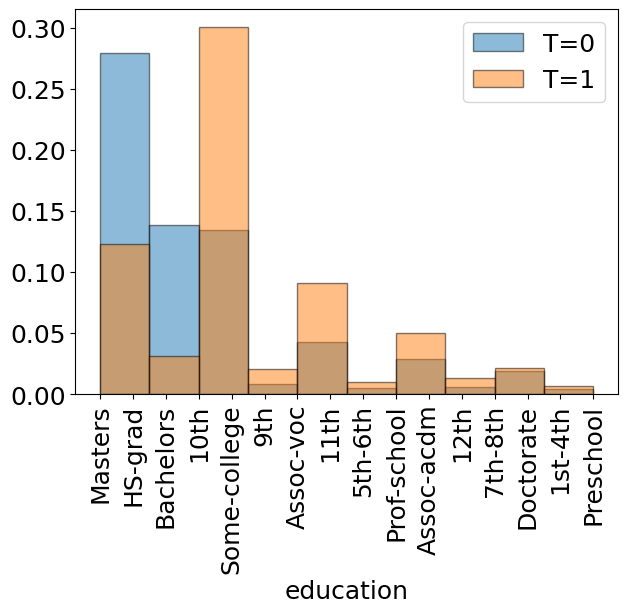

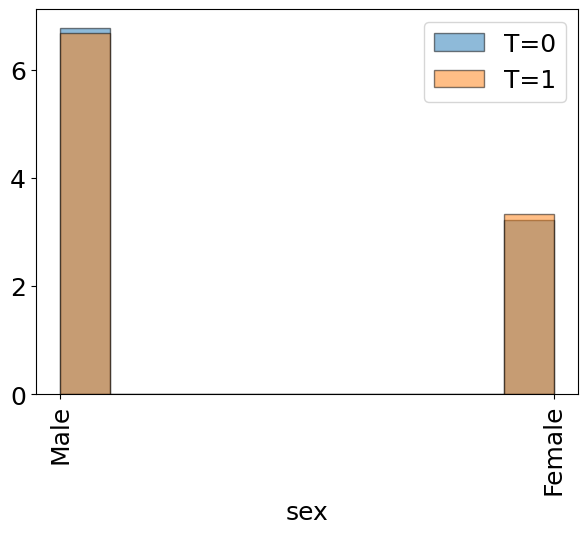

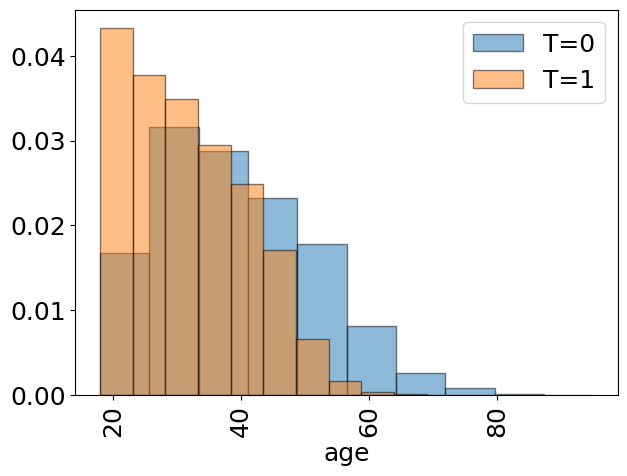

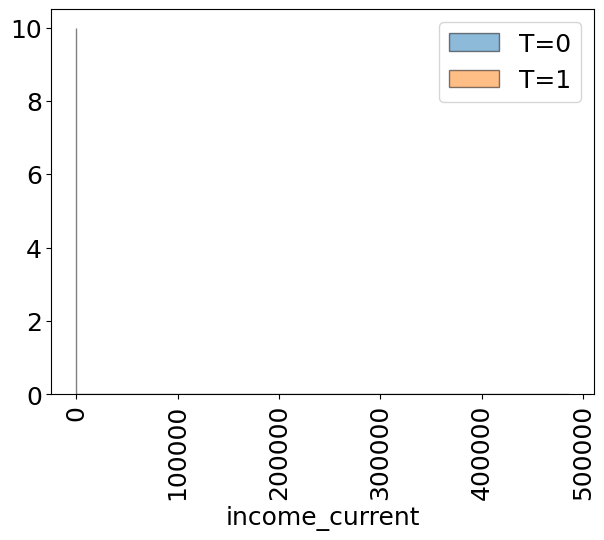

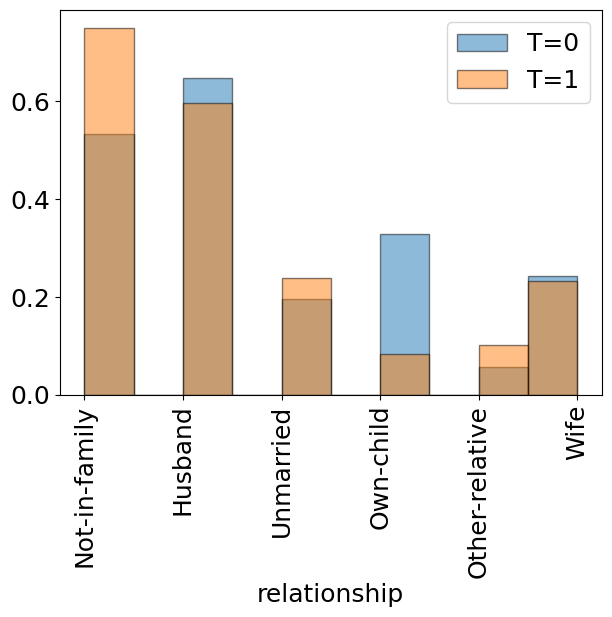

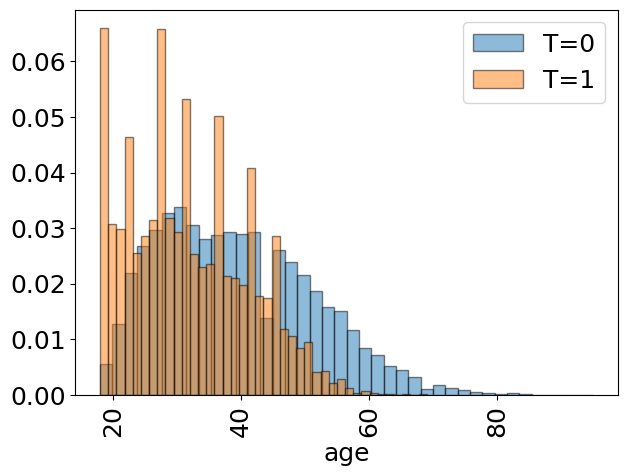

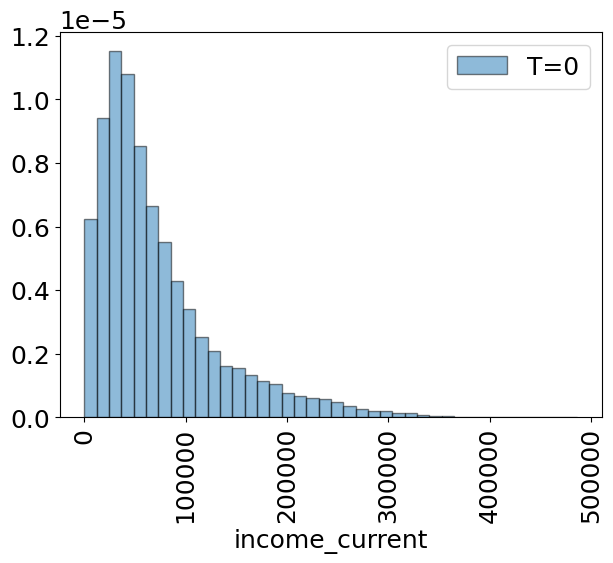

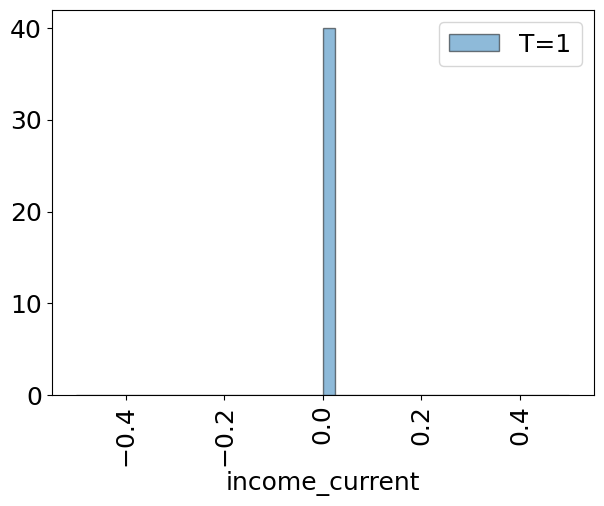

In [33]:
# Treatment indicator
T = 1*(df['studies']=='Full-time studies')

# Visualize variables
for c in a_cols:
    plt.hist(df[T==0][c], alpha=0.5, edgecolor='k', label='T=0', density=True)
    plt.hist(df[T==1][c], alpha=0.5, edgecolor='k', label='T=1', density=True)
    plt.legend()
    plt.xticks(rotation=90)
    plt.xlabel(c)
    plt.show()

c = 'age'
bins = 40
plt.hist(df[T==0][c], alpha=0.5, edgecolor='k', label='T=0', density=True, bins=bins)
plt.hist(df[T==1][c], alpha=0.5, edgecolor='k', label='T=1', density=True, bins=bins)
plt.legend()
plt.xticks(rotation=90)
plt.xlabel(c)
plt.show()


c = 'income_current'
bins = 40
plt.hist(df[T==0][c], alpha=0.5, edgecolor='k', label='T=0', density=True, bins=bins)
plt.legend()
plt.xticks(rotation=90)
plt.xlabel(c)
plt.show()

plt.hist(df[T==1][c], alpha=0.5, edgecolor='k', label='T=1', density=True, bins=bins)
plt.legend()
plt.xticks(rotation=90)
plt.xlabel(c)
plt.show()

...
<br/><br/><br/><br/><br/><br/><br/><br/><br/><br/><br/><br/>
# Take-aways from overlap check?

## First, let's restrict our study population

In [35]:
df = df[(df['age']>=20) & (df['age']<=55)]
df

,native-country,sex,race,age,education,workclass,occupation,marital-status,relationship,capital-net,hours-per-week,education-num,income_current,studies,income
2,United-States,Male,White,47.0,Masters,Self-emp-inc,Exec-managerial,Married,Not-in-family,0.0,52.0,14.0,136003.0,No studies,160004.0
3,United-States,Male,Black,34.0,HS-grad,Private,Machine-op-inspct,Never-married,Husband,0.0,14.0,9.0,12450.0,No studies,90952.0
5,United-States,Female,White,42.0,Some-college,Local-gov,Adm-clerical,Married,Wife,0.0,47.0,10.0,0.0,Full-time studies,138805.0
6,United-States,Male,White,30.0,HS-grad,State-gov,Tech-support,Never-married,Other-relative,-0.0,8.0,9.0,0.0,Full-time studies,171897.0
10,United-States,Female,White,26.0,HS-grad,Private,Adm-clerical,Never-married,Unmarried,0.0,56.0,9.0,0.0,Full-time studies,89268.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49993,United-States,Female,White,32.0,HS-grad,Private,Other-service,Married,Wife,-0.0,0.0,9.0,14131.0,No studies,104855.0
49994,United-States,Male,White,48.0,Assoc-voc,Self-emp-not-inc,Craft-repair,Divorced,Not-in-family,0.0,37.0,11.0,13609.0,No studies,113129.0
49997,United-States,Male,White,52.0,7th-8th,Private,Transport-moving,Married,Other-relative,0.0,54.0,4.0,0.0,Full-time studies,119330.0
49998,United-States,Male,White,24.0,Bachelors,Private,Exec-managerial,Never-married,Not-in-family,-0.0,56.0,13.0,18770.0,No studies,124056.0


## Second, let's restrict our adjustment set

In [38]:
a_cols = [c for c in a_cols if not c == 'income_current']
a_cols

['education', 'sex', 'age', 'relationship']

# OK, we know...
* Our target parameter (ATE)
* Our study population
* Our adjustment set
* Our statistical estimand
* Something about treatment overlap

## Let's do some estimation!

## For reference, let's create a Difference-in-means (DIM) estimate of ATE

In [42]:
T = 1*(df['studies']=='Full-time studies')
ATE_dim = df[T==1]['income'].mean() - df[T==0]['income'].mean()

print('ATE (DiM): $%d' % ATE_dim)

ATE (DiM): $23581


<br/><br/>
# Next, let's do a regression-based estimate

In [55]:
# Let's hold out 20% of data for testing/estimating effects using train_test_split
df_tr, df_te = train_test_split(df, test_size=.2)

# Training samples
A_tr = df_tr[a_cols]
Y_tr = df_tr[y_col]
T_tr = 1*(df_tr[t_col]=='Full-time studies')

# Test samples
A_te = df_te[a_cols]
Y_te = df_te[y_col]
T_te = 1*(df_te[t_col]=='Full-time studies')

# We need to standardize and dichotomize features
# We can use the "SubsetTransformer" which is part of IncomeSim/util.py
tf = SubsetTransformer().fit(df_tr)

# Lets store the post-transformation columns
columns_tf = tf.transform(A_tr).columns

# And have a look at the transformed data
...
tf.transform(A_tr)

,age,sex_Female,sex_Male,education_10th,education_11th,education_12th,education_1st-4th,education_5th-6th,education_7th-8th,education_9th,...,education_Masters,education_Preschool,education_Prof-school,education_Some-college,relationship_Husband,relationship_Not-in-family,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife
34147,1.079026,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
47637,1.932869,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
6736,0.118452,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
47041,1.079026,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
43987,0.758834,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5049,-0.521931,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
46746,-1.162313,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3110,-0.628661,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
11033,0.652104,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


## Let's try fitting a T-learner with Ridge regression

A T-learner estimates the potential outcomes under treatment and control separately. Under conditional exchangeability (ignorability) w.r.t. $X$, we have

$$
\mu_t(x) = \mathbb{E}[Y(t) \mid X=x] = \mathbb{E}[Y \mid T=t, X=x]
$$

We can estimate $\mu_t$ for $t \in \{0,1\}$ separately as two regressions

$$
\hat{\mu}_t(x) = \mbox{arg} \min_f \frac{1}{n_t}\sum_{i : t_i=t} (f(x_i) - y_i)^2
$$

The minimizer of the mean-squared error (MSE) is the conditional expectation. 

Then, we can estimate the conditional average treatment effect (CATE)
$$
\hat{\tau}(x) = \hat{\mu}_1(x) - \hat{\mu}_0(x)
$$
and the average treatment effect (ATE)
$$
\hat{\tau} =  \frac{1}{n}\sum_{i=1}^n \hat{\tau}(x_i) = \frac{1}{n}\sum_{i=1}^n (\hat{\mu}_1(x_i) - \hat{\mu}_0(x_i))
$$

In [61]:
# Let's use scikit-learns grid search
param_grid = {'alpha': [0.1, 1.0, 10.]}

mu0_r = GridSearchCV(Ridge(), param_grid=param_grid).fit(tf.transform(A_tr[T_tr==0]), Y_tr[T_tr==0])
mu1_r = GridSearchCV(Ridge(), param_grid=param_grid).fit(tf.transform(A_tr[T_tr==1]), Y_tr[T_tr==1])

# Compute the R2 score
R20_r = r2_score(Y_te[T_te==0], mu0_r.predict(tf.transform(A_te[T_te==0])))
R21_r = r2_score(Y_te[T_te==1], mu1_r.predict(tf.transform(A_te[T_te==1])))

print(R20_r, R21_r)

0.19747966650879678 0.07174103319129821


In [65]:
# Estimate CATE and ATE
CATE_r = mu1_r.predict(tf.transform(A_te)) - mu0_r.predict(tf.transform(A_te))
ATE_r = CATE_r.mean()

print('ATE (Ridge): $%d' % ATE_r)

ATE (Ridge): $26525


<br/><br/><br/>
## Are these results good enough? What about a different model?

In [66]:
# Let's use scikit-learns grid search
param_grid = {'min_samples_leaf': [10, 20, 50]}

mu0_rf = GridSearchCV(RandomForestRegressor(), param_grid=param_grid).fit(tf.transform(A_tr[T_tr==0]), Y_tr[T_tr==0])
mu1_rf = GridSearchCV(RandomForestRegressor(), param_grid=param_grid).fit(tf.transform(A_tr[T_tr==1]), Y_tr[T_tr==1])

# Compute the R2 score
R20_rf = r2_score(Y_te[T_te==0], mu0_rf.predict(tf.transform(A_te[T_te==0])))
R21_rf = r2_score(Y_te[T_te==1], mu1_rf.predict(tf.transform(A_te[T_te==1])))

print(R20_rf, R21_rf)

0.1914854188077455 0.05279586061331021


In [68]:
# Estimate CATE and ATE
CATE_rf = mu1_rf.predict(tf.transform(A_te)) - mu0_rf.predict(tf.transform(A_te))
ATE_rf = CATE_rf.mean()

print('ATE (Random Forest): $%d' % ATE_rf)

ATE (Random Forest): $25672


<br/><br/><br/>
## Are these results good enough? What about a different adjustment set?

In [71]:
a_cols_ext = x_cols
A_tr_ext = df_tr[a_cols_ext]
A_te_ext = df_te[a_cols_ext]

# Repeat what we did before
# Let's use scikit-learns grid search
param_grid = {'alpha': [0.1, 1.0, 10.]}

mu0_r_ext = GridSearchCV(Ridge(), param_grid=param_grid).fit(tf.transform(A_tr_ext[T_tr==0]), Y_tr[T_tr==0])
mu1_r_ext = GridSearchCV(Ridge(), param_grid=param_grid).fit(tf.transform(A_tr_ext[T_tr==1]), Y_tr[T_tr==1])

# Compute the R2 score
R20_r_ext = r2_score(Y_te[T_te==0], mu0_r_ext.predict(tf.transform(A_te_ext[T_te==0])))
R21_r_ext = r2_score(Y_te[T_te==1], mu1_r_ext.predict(tf.transform(A_te_ext[T_te==1])))

print(R20_r_ext, R21_r_ext)

0.4288816559619337 0.07663990734290316


In [73]:
# Estimate CATE and ATE
CATE_r_ext = mu1_r_ext.predict(tf.transform(A_te_ext)) - mu0_r_ext.predict(tf.transform(A_te_ext))
ATE_r_ext = CATE_r_ext.mean()

print('ATE (Ridge, ext): $%d' % ATE_r_ext)

ATE (Ridge, ext): $31641


<br/><br/><br/>
## What happens to our results?
* How do the R2 compare?
* How do the ATE estimates?

<br/><br/><br/>
## What would happen if we accidentally included "income_current"?

A so-called post-treatment variable

<br/><br/><br/>
# Finally, let's do a propensity-weighting estimate

Assume that $p(T=t \mid X=x) > 0$ for all $x, t$. Then, under conditional exchangeability w.r.t. $X$ and consistency, 

$$
\mu_1 = \mathbb{E}[Y(1)] = \mathbb{E}\left[Y \frac{p(T=t)}{p(T=t \mid X)} \mid T=t \right] = \mathbb{E}\left[Y \frac{p(T=t)}{e_t(X)} \mid T=t \right]
$$
where $e_1(x) = e(x) = p(T=1 \mid X=x)$ is the propensity score w.r.t. $x$ and $e_0(x) = 1-e(x)$.

We can easily estimate $p(T=t)$. This is just the maginal rate of treatment. 

$e(x) = p(T=1 \mid X=x)$ is a conditional probability of a binary variable. We can estimate this using a stochastic classifier such as logistic regression or random forests! Given an estimate $\hat{e}(x)$, we can estimate expected potential outcomes 

$$
\hat{\mu_t} = \frac{1}{n_t}\sum_{i : t_i = t}\frac{\hat{p}(T=t)}{\hat{e}_t(x_i)} y_i
$$
and the average treatment effect
$$
\hat{\tau} = \hat{\mu_1} - \hat{\mu_0}
$$

Let's do that!

In [78]:

# Fit a propensity model, e.g., logistic regression
e1_lr = LogisticRegression().fit(tf.transform(A_tr), T_tr)

# Evaluate propensity on training set and test set
e1_lr_tr = e1_lr.predict_proba(tf.transform(A_tr))[:,1]
e1_lr_te = e1_lr.predict_proba(tf.transform(A_te))[:,1]

# Evaluate the propensity model
AUC_lr = roc_auc_score(T_te, e1_lr_te)
AUC_lr

0.8370205606896204

<br/><br/><br/>
## Let's assess calibration

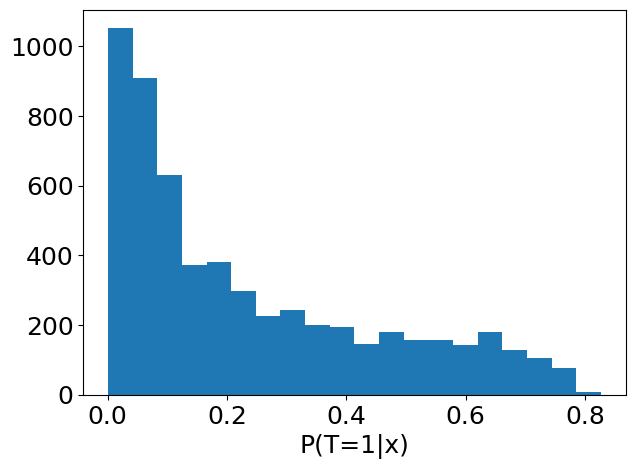

In [82]:
plt.hist(e1_lr_te, bins=20)
plt.xlabel('P(T=1|x)')
plt.show()

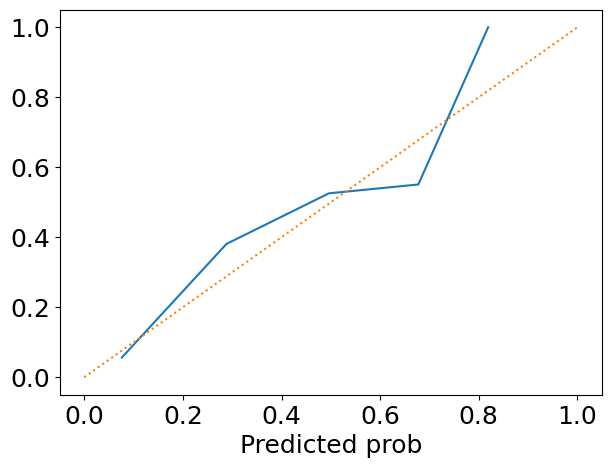

In [87]:
# Compute calibration curve
rate_lr, pred_lr = calibration_curve(T_te, e1_lr_te)

plt.plot(pred_lr, rate_lr)
plt.xlabel('Predicted prob')
plt.plot([0,1],[0,1], ':')

<br/><br/><br/>
## Let's compute the IPW estimate

In [101]:
# Marginal treatment probability
p1 = T_tr.mean()
p0 = 1-p1

# Importance weights for treated
ipw1 = p1/e1_lr_te[T_te==1]
# Importance weights for control
ipw0 = p0/(1-e1_lr_te[T_te==0])

# Horvitz-Thompson estimator
ATE_ipw = (df_te[T_te==1]['income']*ipw1).mean() - (df_te[T_te==0]['income']*ipw0).mean()

print(ATE_ipw)

-9728.198722296336


<br/><br/><br/><br/><br/><br/>
## Does that look right?

### Let's try one more thing

In [104]:
# Importance weights for treated
ipw1h = ipw1/ipw1.mean()
# Importance weights for control
ipw0h = ipw0/ipw0.mean()

# Hajek estimator (normalized weights)
ATE_ipwn = (df_te[T_te==1]['income']*ipw1h).mean() - (df_te[T_te==0]['income']*ipw0h).mean()

ATE_ipwn

24711.04290459327

# OK, we have several estimates...

<br/><br/><br/>
# How do we know if they are any good?

To confirm ATE in the real world, we must run an experiment and estimate it. This will...
* Gathering a population
* Randomly assigning them to $T=0$ and $T=1$
* Observing outcomes and computing averages

## We can simulate that by setting a flag ```-p``` in the generator

In [ ]:
# Generate according to T=0 policy
%run generate.py -n 50000 -T 10 -p no

# Generate according to T=1 policy
%run generate.py -n 50000 -T 10 -p full

In [106]:
# Load datasets
df1 = pd.read_pickle('data/income_full_n50000_T10_s0.pkl')
df0 = pd.read_pickle('data/income_no_n50000_T10_s0.pkl')

# Restrict populations in the same way to  20 <= Age <= 55
df1 = df1[(df1['age']>=20) & (df1['age']<=55)]
df0 = df0[(df0['age']>=20) & (df0['age']<=55)]

# On-policy ATE estimate
ATE_onp = df1['income'].mean() - df0['income'].mean()
ATE_onp

29240.343818430658

<br/><br/><br/>
# If we have time, we can also estimate CATE as a function of age

## Let's use our estimates from the Ridge and Random forest

In [ ]:
df_cate_r = ...